In [200]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import pickle
from sklearn.ensemble import VotingClassifier
plt.rcParams['figure.figsize'] = (10, 10)
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns


In [3]:
data = pd.read_csv('Amex_training.csv')

## Defining Transformers for Input Pipeline

In [4]:
class LogTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, shift = 1):
        self.shift = shift
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X = X.astype('float64')
        return np.log(X + self.shift)

class DFTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, col_names):
        self.col_names = col_names
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return pd.DataFrame(X, columns = self.col_names)


In [5]:
n_data = data.copy()
target = n_data.pop("default_ind")

In [6]:
cat_cols = []
for cols in data:
    if cols == 'default_ind':
        continue
    num = data[cols].unique().size
    if num <= 30:
        cat_cols.append(cols)

In [7]:
num_cols = [i for i in data.columns if i not in cat_cols and i != 'default_ind']
weight = (target==0).sum()/(target == 1).sum()

In [8]:
def submission(model):
    test_data = pd.read_csv('Amex_Test_data.csv')
    preds = model.predict(test_data)
    app_key = pd.read_csv('app_key.csv')
    app_key['preds'] = preds
    return app_key

## Finding out strongly correlated features

In [10]:
corrs = data.corr() 

threshold = 0.7
buf = []

for cols1 in corrs:
    buf.append(cols1)
    for cols2 in corrs:
        if cols2 not in buf:
            val = corrs.loc[cols1, cols2]
            if abs(val) >= threshold:
                print(f'{cols1}, {cols2}:{val}')

mvar1, mvar42:-0.7743396625511232
mvar4, mvar46:0.8817110647852113
mvar7, mvar10:0.892973116736524
mvar9, mvar32:0.718002549421013
mvar16, mvar17:0.9374173170216952
mvar16, mvar18:0.928629316362157
mvar17, mvar18:0.9897991981977573
mvar19, mvar20:0.985329675603559
mvar21, mvar22:0.7036380777721649
mvar22, mvar23:0.8945648407025417
mvar25, mvar26:0.7085668467676325
mvar25, mvar27:0.7559996777476152
mvar26, mvar27:0.9133317378330063
mvar32, mvar37:0.8664394304224051


In [11]:
corrs['default_ind'] # [42, 4, 7, 32, 16, 17, 19, 21, 22, 25]

mvar1         -0.368350
mvar2          0.206396
mvar3          0.180356
mvar4          0.129412
mvar5          0.085536
mvar6         -0.135156
mvar7         -0.097629
mvar8         -0.195159
mvar9         -0.179666
mvar10        -0.149656
mvar11         0.027521
mvar12        -0.045496
mvar13        -0.087363
mvar14         0.001922
mvar15        -0.106269
mvar16         0.237592
mvar17         0.235242
mvar18         0.231353
mvar19         0.111349
mvar20         0.105365
mvar21         0.278938
mvar22         0.281273
mvar23         0.274292
mvar24         0.058889
mvar25        -0.191359
mvar26        -0.192040
mvar27        -0.193599
mvar28        -0.198825
mvar29        -0.187419
mvar30        -0.109114
mvar31        -0.108861
mvar32        -0.193772
mvar33        -0.125520
mvar34         0.134574
mvar35         0.236881
mvar36         0.154670
mvar37        -0.182224
mvar38         0.127458
mvar39         0.131056
mvar40         0.161234
mvar41         0.101558
mvar42         0

In [12]:
threshold = 0.70
for cols in n_data.columns:
    num = n_data[cols].notnull().sum()
    if num/n_data.shape[0] < threshold:
        print(cols, num/n_data.shape[0])

mvar11 0.437144578313253
mvar15 0.5961566265060241
mvar22 0.6305060240963856
mvar23 0.4902289156626506
mvar30 0.5423132530120482
mvar31 0.29471084337349396
mvar35 0.5799036144578313
mvar40 0.21602409638554218
mvar41 0.3100722891566265
mvar45 0.44674698795180723


Removing strongly correlated features to prevent baised statistics of feature importance

In [13]:
cat_cols

['mvar16',
 'mvar17',
 'mvar18',
 'mvar19',
 'mvar20',
 'mvar34',
 'mvar35',
 'mvar39',
 'mvar45',
 'mvar46',
 'mvar47']

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83000 entries, 0 to 82999
Data columns (total 48 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   mvar1        79267 non-null  float64
 1   mvar2        77114 non-null  float64
 2   mvar3        82465 non-null  float64
 3   mvar4        82465 non-null  float64
 4   mvar5        82465 non-null  float64
 5   mvar6        63299 non-null  float64
 6   mvar7        75326 non-null  float64
 7   mvar8        63291 non-null  float64
 8   mvar9        71318 non-null  float64
 9   mvar10       82465 non-null  float64
 10  mvar11       36283 non-null  float64
 11  mvar12       68422 non-null  float64
 12  mvar13       73311 non-null  float64
 13  mvar14       83000 non-null  int64  
 14  mvar15       49481 non-null  float64
 15  mvar16       63757 non-null  float64
 16  mvar17       66501 non-null  float64
 17  mvar18       67641 non-null  float64
 18  mvar19       82995 non-null  float64
 19  mvar

## Functions to build input pipeline, train models and perform hyperparameter tuning

In [175]:
# Bayesian hyperparameter tuning on the model 
# Provide the chosen column names, builds the imputer and transformation pipeline with the model attached at the end
# Does Bayesian hyperparameter tuning and returns the results and the best model found

def train_model(model, chosen_cols, p_grid, data, target, n_iter):
    ccat_cols = [i for i in cat_cols if i in chosen_cols]
    cnum_cols = [i for i in num_cols if i in chosen_cols]
    imputer = ColumnTransformer([('mode', IterativeImputer(initial_strategy = 'most_frequent'), ccat_cols),
                             ('median', IterativeImputer(initial_strategy = 'median'), cnum_cols)])
    
    model_pipe = Pipeline([('imp', imputer), 
                    ('df', DFTransformer(ccat_cols + cnum_cols)),
                    ('ss', StandardScaler()),
                    ('model', model)])
    
    model_bayes =  BayesSearchCV(model_pipe, p_grid, n_iter = n_iter, scoring = 'f1', cv = 5, verbose = 3, return_train_score = True, n_jobs = -1)
    
    model_bayes.fit(data, target)
    
    cv = cross_validate(model_bayes.best_estimator_, n_data, target, cv = 5, n_jobs = -1, return_train_score = True, scoring = 'f1')
    te_sc = cv['test_score'].mean()
    te_tr = cv['train_score'].mean()
    
    print(f'Train: {te_tr}, Test: {te_sc}')
    
    return model_bayes, cv   


def train_model_pca(model, chosen_cols, p_grid, data, target, n_iter, n_pca):
    ccat_cols = [i for i in cat_cols if i in chosen_cols]
    cnum_cols = [i for i in num_cols if i in chosen_cols]
    imputer = ColumnTransformer([('mode', IterativeImputer(initial_strategy = 'most_frequent'), ccat_cols),
                             ('median', IterativeImputer(initial_strategy = 'median'), cnum_cols)])
    
    model_pipe = Pipeline([('imp', imputer), 
                    ('df', DFTransformer(ccat_cols + cnum_cols)),
                    ('pca', PCA(n_pca)),
                    ('ss', StandardScaler()),
                    ('model', model)])
    
    model_bayes =  BayesSearchCV(model_pipe, p_grid, n_iter = n_iter, scoring = 'f1', cv = 5, verbose = 3, return_train_score = True, n_jobs = -1)
    
    model_bayes.fit(data, target)
    
    cv = cross_validate(model_bayes.best_estimator_, n_data, target, cv = 5, n_jobs = -1, return_train_score = True, scoring = 'f1')
    te_sc = cv['test_score'].mean()
    te_tr = cv['train_score'].mean()
    
    print(f'Train: {te_tr}, Test: {te_sc}')
    
    return model_bayes, cv   
    

## Function to Generate Feature Importance plots

In [44]:
# Plot the feature importances

def plot_fi(cols, fi, title):
    fi_s = pd.Series(fi, cols)
    fi_sorted = fi_s.iloc[fi_s.argsort()][::-1]
    fi_sorted.plot(kind = 'barh')
    plt.title(title)
    plt.xlabel('Importance score')
    return fi_sorted
    

In [45]:
# Logistic Regression 

In [46]:
remove = [11, 15, 22, 23, 30, 31, 35, 40, 41, 45, 42, 46, 7, 16, 17, 20, 26, 27, 32]
removed = [f'mvar{i}' for i in remove]
chosen = [i for i in n_data.columns if i not in removed]

ccat_cols = [i for i in cat_cols if i in chosen]
cnum_cols = [i for i in num_cols if i in chosen]

## Defining Search Spaces for various models for hyperparameter tuning

### LR

In [47]:
lr_params = {'model__C':Real(1e-6, 1e6),
             'model__penalty':Categorical(['l2', 'l1', 'elasticnet', 'none'])}

## XGBoost

In [49]:
xg_params = {
        'model__n_estimators': Integer(20, 500),
        'model__learning_rate': Real(0.01, 2.0, 'log-uniform'),
        'model__min_child_weight': Integer(0, 10),
        'model__max_depth': Integer(2, 10),
        'model__gamma': Real(1e-9, 1000, 'uniform'),
        'model__reg_lambda': Real(1e-9, 1000, 'uniform'),
        'model__reg_alpha': Real(1e-9, 1000, 'uniform'),
        'model__subsample': Real(0.01, 1.0, 'uniform'),
        'model__colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'model__colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'model__colsample_bynode': Real(0.01, 1, 'uniform'), 
        
       
    }    

## LGBM

In [51]:
lgbm_spaces = {
        'model__learning_rate': (0.01, 1.0, 'uniform'),
        'model__num_leaves': Integer(10, 300),      
        'model__max_depth': Integer(0, 50),
        'model__n_estimators': Integer(20, 500),
        'model__reg_lambda': Real(1e-9, 1000, 'uniform'),
        'model__reg_alpha': Real(1e-9, 1000, 'uniform'),
        'model__min_child_samples': Integer(10, 350),
        'model__subsample': Real(0.01, 1.0, 'uniform'),
        'model__colsample_bytree': Real(0.01, 1.0, 'uniform'),
        'model__min_child_weight': Integer(0, 10),
        
    }   

## Catboost

In [52]:
cb_spaces = {
        'model__learning_rate': (0.01, 2.0, 'uniform'),
        'model__max_depth': Integer(2, 10),
        'model__n_estimators': Integer(20, 500),
        'model__num_leaves': Integer(10, 300),      
        'model__reg_lambda': Real(1e-9, 1000, 'uniform'),
        'model__min_child_samples': Integer(0, 350),
        'model__subsample': Real(0.01, 1.0, 'uniform'),
        'model__colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        
}

## Train and return the best performing models and the voting classifierwith and without PCA

In [176]:
def create_models(chosen, n_data, target, n_iter):
    # Train LR
    print('Training LR')
    lr_model = LogisticRegression(solver = 'saga', max_iter = 3000, l1_ratio = 0.5, class_weight = 'balanced')
    lr_bayes = train_model(lr_model, chosen, lr_params, n_data, target, n_iter)
    lr_best = lr_bayes[0].best_estimator_
    print('----------------------------------------------------------------------')
    
    # Train XGB
    print('Traning XGB')
    xg_model = XGBClassifier(scale_pos_weight = weight)
    xb_bayes = train_model(xg_model, chosen, xg_params, n_data, target, n_iter)
    xgb_best = xb_bayes[0].best_estimator_
    print('----------------------------------------------------------------------')
    
    # Train LGBM
    print('Training LGBM')
    lgbm_model = LGBMClassifier(scale_pos_weight = weight)
    lgbm_bayes  = train_model(lgbm_model, chosen, lgbm_spaces, n_data, target, n_iter)
    lgbm_best = lgbm_bayes[0].best_estimator_
    print('----------------------------------------------------------------------')
    
    # Train CB
    print('Training CB')
    cb_model = CatBoostClassifier(scale_pos_weight = weight, grow_policy = 'Lossguide')
    cb_bayes  = train_model(cb_model, chosen, cb_spaces, n_data, target, n_iter)
    cb_best = cb_bayes[0].best_estimator_
    print('----------------------------------------------------------------------')
    
    
    vc = VotingClassifier([('xgb', clone(xgb_best)), ('lgbm', clone(lgbm_best)), ('cb', clone(cb_best)), ('lr', clone(lr_best))], voting = 'soft')
    vc_cv = cross_validate(vc, n_data, target, cv = 5, scoring = 'f1', return_train_score = True, n_jobs = -1)
    
    print('Voting Classifier CV')
    print(vc_cv)
    
    return lr_bayes, xb_bayes, lgbm_bayes, cb_bayes, vc, vc_cv


def create_models_PCA(chosen, n_data, target, n_iter, n_pca):
    # Train LR
    print('Training LR')
    lr_model = LogisticRegression(solver = 'saga', max_iter = 3000, l1_ratio = 0.5, class_weight = 'balanced')
    lr_bayes = train_model_pca(lr_model, chosen, lr_params, n_data, target, n_iter, n_pca)
    lr_best = lr_bayes[0].best_estimator_
    print('----------------------------------------------------------------------')
    
    # Train XGB
    print('Traning XGB')
    xg_model = XGBClassifier(scale_pos_weight = weight)
    xb_bayes = train_model_pca(xg_model, chosen, xg_params, n_data, target, n_iter, n_pca)
    xgb_best = xb_bayes[0].best_estimator_
    print('----------------------------------------------------------------------')
    
    # Train LGBM
    print('Training LGBM')
    lgbm_model = LGBMClassifier(scale_pos_weight = weight)
    lgbm_bayes  = train_model_pca(lgbm_model, chosen, lgbm_spaces, n_data, target, n_iter, n_pca)
    lgbm_best = lgbm_bayes[0].best_estimator_
    print('----------------------------------------------------------------------')
    
    # Train CB
    print('Training CB')
    cb_model = CatBoostClassifier(scale_pos_weight = weight, grow_policy = 'Lossguide')
    cb_bayes  = train_model_pca(cb_model, chosen, cb_spaces, n_data, target, n_iter, n_pca)
    cb_best = cb_bayes[0].best_estimator_
    print('----------------------------------------------------------------------')
    
    
    vc = VotingClassifier([('xgb', clone(xgb_best)), ('lgbm', clone(lgbm_best)), ('cb', clone(cb_best)), ('lr', clone(lr_best))], voting = 'soft')
    vc_cv = cross_validate(vc, n_data, target, cv = 5, scoring = 'f1', return_train_score = True, n_jobs = -1)
    
    print('Voting Classifier CV')
    print(vc_cv)
    
    return lr_bayes, xb_bayes, lgbm_bayes, cb_bayes, vc, vc_cv
    
    
    
    
    

## Removing selected columns

In [57]:
remove = [11, 15, 22, 23, 30, 31, 35, 40, 41, 45, 42, 46, 7, 16, 17, 20, 26, 27, 32]
removed = [f'mvar{i}' for i in remove]
chosen = [i for i in n_data.columns if i not in removed]


## Training without strongly correlated features

In [58]:
mods1 = create_models(chosen, n_data, target, 10) 

Training LR
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Train: 0.5800442692601298, Test: 0.5793544744507868
----------------------------------------------------------------------
Traning XGB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train: 0.5772267665370047, Test: 0.5749862787467861
----------------------------------------------------------------------
Training LGBM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for ea

129:	learn: 0.5489825	total: 2.81s	remaining: 7.03s
130:	learn: 0.5489340	total: 2.83s	remaining: 6.99s
131:	learn: 0.5488021	total: 2.85s	remaining: 6.97s
132:	learn: 0.5487136	total: 2.87s	remaining: 6.94s
133:	learn: 0.5486888	total: 2.88s	remaining: 6.9s
134:	learn: 0.5486023	total: 2.9s	remaining: 6.87s
135:	learn: 0.5485006	total: 2.92s	remaining: 6.84s
136:	learn: 0.5483777	total: 2.93s	remaining: 6.81s
137:	learn: 0.5483068	total: 2.95s	remaining: 6.78s
138:	learn: 0.5482393	total: 2.97s	remaining: 6.75s
139:	learn: 0.5481701	total: 2.98s	remaining: 6.71s
140:	learn: 0.5480825	total: 3s	remaining: 6.68s
141:	learn: 0.5480249	total: 3.02s	remaining: 6.66s
142:	learn: 0.5479313	total: 3.04s	remaining: 6.63s
143:	learn: 0.5478021	total: 3.06s	remaining: 6.61s
144:	learn: 0.5477096	total: 3.08s	remaining: 6.58s
145:	learn: 0.5476356	total: 3.1s	remaining: 6.56s
146:	learn: 0.5475887	total: 3.12s	remaining: 6.53s
147:	learn: 0.5474415	total: 3.14s	remaining: 6.51s
148:	learn: 0.5474

289:	learn: 0.5366687	total: 5.72s	remaining: 3.25s
290:	learn: 0.5365422	total: 5.74s	remaining: 3.23s
291:	learn: 0.5364984	total: 5.76s	remaining: 3.21s
292:	learn: 0.5363836	total: 5.78s	remaining: 3.19s
293:	learn: 0.5362695	total: 5.79s	remaining: 3.17s
294:	learn: 0.5362212	total: 5.81s	remaining: 3.15s
295:	learn: 0.5361710	total: 5.83s	remaining: 3.13s
296:	learn: 0.5361468	total: 5.85s	remaining: 3.11s
297:	learn: 0.5361269	total: 5.87s	remaining: 3.09s
298:	learn: 0.5359995	total: 5.88s	remaining: 3.07s
299:	learn: 0.5359752	total: 5.9s	remaining: 3.05s
300:	learn: 0.5359414	total: 5.92s	remaining: 3.03s
301:	learn: 0.5358472	total: 5.93s	remaining: 3.01s
302:	learn: 0.5357666	total: 5.95s	remaining: 2.99s
303:	learn: 0.5357078	total: 5.97s	remaining: 2.96s
304:	learn: 0.5356497	total: 5.99s	remaining: 2.94s
305:	learn: 0.5355449	total: 6s	remaining: 2.92s
306:	learn: 0.5354793	total: 6.02s	remaining: 2.9s
307:	learn: 0.5354197	total: 6.04s	remaining: 2.88s
308:	learn: 0.535

448:	learn: 0.5269648	total: 8.6s	remaining: 115ms
449:	learn: 0.5268866	total: 8.61s	remaining: 95.7ms
450:	learn: 0.5268187	total: 8.63s	remaining: 76.6ms
451:	learn: 0.5267904	total: 8.65s	remaining: 57.4ms
452:	learn: 0.5267537	total: 8.66s	remaining: 38.3ms
453:	learn: 0.5266858	total: 8.68s	remaining: 19.1ms
454:	learn: 0.5266241	total: 8.7s	remaining: 0us
Train: 0.6238164812934901, Test: 0.5913613172930304
----------------------------------------------------------------------
Voting Classifier CV
{'fit_time': array([83.56751895, 82.59614325, 84.76631355, 83.25735092, 83.55954194]), 'score_time': array([0.87865043, 0.47071457, 1.03723764, 0.78489971, 0.78789282]), 'test_score': array([0.5841937 , 0.58300897, 0.59036655, 0.59265689, 0.58698837]), 'train_score': array([0.6004329 , 0.59911818, 0.59749066, 0.59673266, 0.59820963])}


In [62]:
mods1[5]['test_score'].mean()

0.5874428929915559

In [63]:
remove1 = [11, 15, 22, 23, 30, 31, 35, 40, 41, 45]
removed1 = [f'mvar{i}' for i in remove1]
chosen1 = [i for i in n_data.columns if i not in removed1]

## Training with Strongly correlated features

In [65]:
mods2 = create_models(chosen1, n_data, target, 10) 

Training LR
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Train: 0.5808557689060468, Test: 0.5802367141556495
----------------------------------------------------------------------
Traning XGB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:05:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train: 0.5740087708409166, Test: 0.5725136271051321
----------------------------------------------------------------------
Training LGBM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for ea

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


Train: 0.595098377461879, Test: 0.5866243773685704
----------------------------------------------------------------------
Training CB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0:	learn: 0.6219668	total: 8.79ms	remaining: 3.73s
1:	learn: 0.6002568	total: 17.8ms	remaining: 3.75s
2:	learn: 0.5887653	total: 25.4ms	remaining: 3.57s
3:	learn: 0.5843236	total: 33.3ms	remaining: 3.51s
4:	learn: 0.5820722	total: 41.8ms	remaining: 3.51s
5:	learn: 0.5798294	total: 50.1ms	remaining: 3.5s
6:	learn: 0.5775169	total: 58.6ms	remaining: 3.5s
7:	learn: 0.5759874	total: 67ms	remaining: 3.49s
8:	learn: 0.5747327	total: 75.2ms	remaining: 3.47s
9:	learn: 0.5734405	total: 84ms	remaining: 3.48s
10:	learn: 0.5724890	total: 92ms	remaining: 3.46s
11:	learn: 0.5718928	total: 101ms	remaining: 3.46s
12:	learn: 0.5713999	total: 109ms	remaining: 3.44s
13:	learn: 0.5710673	total: 118ms	remaining: 3.45s
14:	learn: 0.5702438	total: 125ms	remaining: 3.42s
15:	learn: 0.5697872	total: 133ms	remaining: 3.39s
16:	learn: 0.5687107	total: 140ms	remaining: 3.37s
17:	learn: 0.5682480	total: 148ms	remaining: 3.35s
18:	learn: 0.5678170	total: 157ms	remaining: 3.35s
19:	learn: 0.5673766	total: 166ms	rema

179:	learn: 0.5481703	total: 1.5s	remaining: 2.04s
180:	learn: 0.5481122	total: 1.51s	remaining: 2.03s
181:	learn: 0.5480202	total: 1.52s	remaining: 2.02s
182:	learn: 0.5479336	total: 1.52s	remaining: 2.02s
183:	learn: 0.5478971	total: 1.53s	remaining: 2.01s
184:	learn: 0.5478219	total: 1.54s	remaining: 2s
185:	learn: 0.5477508	total: 1.55s	remaining: 1.99s
186:	learn: 0.5476920	total: 1.56s	remaining: 1.99s
187:	learn: 0.5476197	total: 1.57s	remaining: 1.98s
188:	learn: 0.5475254	total: 1.58s	remaining: 1.97s
189:	learn: 0.5474247	total: 1.58s	remaining: 1.96s
190:	learn: 0.5473996	total: 1.59s	remaining: 1.95s
191:	learn: 0.5473474	total: 1.6s	remaining: 1.94s
192:	learn: 0.5472487	total: 1.61s	remaining: 1.93s
193:	learn: 0.5472073	total: 1.61s	remaining: 1.92s
194:	learn: 0.5471947	total: 1.62s	remaining: 1.91s
195:	learn: 0.5471340	total: 1.63s	remaining: 1.91s
196:	learn: 0.5470601	total: 1.64s	remaining: 1.9s
197:	learn: 0.5470260	total: 1.65s	remaining: 1.89s
198:	learn: 0.5470

338:	learn: 0.5396188	total: 2.8s	remaining: 711ms
339:	learn: 0.5395422	total: 2.81s	remaining: 702ms
340:	learn: 0.5394827	total: 2.82s	remaining: 694ms
341:	learn: 0.5394752	total: 2.83s	remaining: 686ms
342:	learn: 0.5394594	total: 2.83s	remaining: 677ms
343:	learn: 0.5393673	total: 2.84s	remaining: 669ms
344:	learn: 0.5393114	total: 2.85s	remaining: 661ms
345:	learn: 0.5392623	total: 2.86s	remaining: 653ms
346:	learn: 0.5392168	total: 2.87s	remaining: 644ms
347:	learn: 0.5391812	total: 2.87s	remaining: 636ms
348:	learn: 0.5391381	total: 2.88s	remaining: 628ms
349:	learn: 0.5391065	total: 2.89s	remaining: 619ms
350:	learn: 0.5390670	total: 2.9s	remaining: 611ms
351:	learn: 0.5390194	total: 2.91s	remaining: 603ms
352:	learn: 0.5389793	total: 2.91s	remaining: 594ms
353:	learn: 0.5389180	total: 2.92s	remaining: 586ms
354:	learn: 0.5388513	total: 2.93s	remaining: 578ms
355:	learn: 0.5388007	total: 2.94s	remaining: 570ms
356:	learn: 0.5387492	total: 2.95s	remaining: 561ms
357:	learn: 0.

In [66]:
cat_cols

['mvar16',
 'mvar17',
 'mvar18',
 'mvar19',
 'mvar20',
 'mvar34',
 'mvar35',
 'mvar39',
 'mvar45',
 'mvar46',
 'mvar47']

In [75]:
ccat_cols = [i for i in cat_cols if i in chosen]
cnum_cols = [i for i in num_cols if i in chosen]
imputer = ColumnTransformer([('mode', IterativeImputer(initial_strategy = 'most_frequent'), ccat_cols),
                             ('median', IterativeImputer(initial_strategy = 'median'), cnum_cols)])
    
gnb = Pipeline([('imp', imputer), 
                ('df', DFTransformer(ccat_cols + cnum_cols)),
                ('ss', StandardScaler()),
                ('model', GaussianNB())])

In [77]:
gnb_score = cross_validate(gnb, n_data, target, cv = 5, scoring = 'f1', return_train_score = True)

In [78]:
gnb_score['test_score'].mean()

0.5668427769608668

In [79]:
gnb_score['train_score'].mean()

0.5673884136899605

In [85]:
cbbest = mods1[3][0].best_estimator_

In [86]:
cbbest.fit(n_data, target)

0:	learn: 0.6761678	total: 24.2ms	remaining: 11s
1:	learn: 0.6610914	total: 48.2ms	remaining: 10.9s
2:	learn: 0.6483673	total: 69.9ms	remaining: 10.5s
3:	learn: 0.6376622	total: 93.8ms	remaining: 10.6s
4:	learn: 0.6285841	total: 115ms	remaining: 10.3s
5:	learn: 0.6201748	total: 139ms	remaining: 10.4s
6:	learn: 0.6130840	total: 161ms	remaining: 10.3s
7:	learn: 0.6070382	total: 183ms	remaining: 10.2s
8:	learn: 0.6018056	total: 207ms	remaining: 10.3s
9:	learn: 0.5974005	total: 232ms	remaining: 10.3s
10:	learn: 0.5933897	total: 253ms	remaining: 10.2s
11:	learn: 0.5899247	total: 273ms	remaining: 10.1s
12:	learn: 0.5868972	total: 295ms	remaining: 10s
13:	learn: 0.5840905	total: 316ms	remaining: 9.96s
14:	learn: 0.5817736	total: 337ms	remaining: 9.9s
15:	learn: 0.5796121	total: 360ms	remaining: 9.88s
16:	learn: 0.5776975	total: 382ms	remaining: 9.85s
17:	learn: 0.5761108	total: 403ms	remaining: 9.79s
18:	learn: 0.5746248	total: 424ms	remaining: 9.72s
19:	learn: 0.5731654	total: 447ms	remainin

170:	learn: 0.5455684	total: 3.4s	remaining: 5.64s
171:	learn: 0.5454670	total: 3.42s	remaining: 5.62s
172:	learn: 0.5453800	total: 3.44s	remaining: 5.6s
173:	learn: 0.5452912	total: 3.45s	remaining: 5.58s
174:	learn: 0.5452222	total: 3.47s	remaining: 5.55s
175:	learn: 0.5451863	total: 3.49s	remaining: 5.53s
176:	learn: 0.5450973	total: 3.5s	remaining: 5.5s
177:	learn: 0.5449842	total: 3.52s	remaining: 5.48s
178:	learn: 0.5448723	total: 3.54s	remaining: 5.46s
179:	learn: 0.5448236	total: 3.56s	remaining: 5.43s
180:	learn: 0.5447416	total: 3.58s	remaining: 5.41s
181:	learn: 0.5446201	total: 3.59s	remaining: 5.39s
182:	learn: 0.5445331	total: 3.61s	remaining: 5.37s
183:	learn: 0.5445017	total: 3.63s	remaining: 5.34s
184:	learn: 0.5443785	total: 3.65s	remaining: 5.32s
185:	learn: 0.5443603	total: 3.66s	remaining: 5.29s
186:	learn: 0.5443444	total: 3.67s	remaining: 5.26s
187:	learn: 0.5442950	total: 3.69s	remaining: 5.24s
188:	learn: 0.5442054	total: 3.71s	remaining: 5.21s
189:	learn: 0.54

331:	learn: 0.5339069	total: 6.3s	remaining: 2.33s
332:	learn: 0.5338694	total: 6.32s	remaining: 2.31s
333:	learn: 0.5337885	total: 6.33s	remaining: 2.29s
334:	learn: 0.5337652	total: 6.35s	remaining: 2.27s
335:	learn: 0.5337078	total: 6.37s	remaining: 2.25s
336:	learn: 0.5336384	total: 6.38s	remaining: 2.23s
337:	learn: 0.5335745	total: 6.4s	remaining: 2.21s
338:	learn: 0.5335643	total: 6.41s	remaining: 2.19s
339:	learn: 0.5335374	total: 6.43s	remaining: 2.17s
340:	learn: 0.5334678	total: 6.45s	remaining: 2.16s
341:	learn: 0.5333799	total: 6.47s	remaining: 2.14s
342:	learn: 0.5332802	total: 6.49s	remaining: 2.12s
343:	learn: 0.5332544	total: 6.5s	remaining: 2.1s
344:	learn: 0.5332076	total: 6.52s	remaining: 2.08s
345:	learn: 0.5331247	total: 6.54s	remaining: 2.06s
346:	learn: 0.5330233	total: 6.55s	remaining: 2.04s
347:	learn: 0.5329837	total: 6.57s	remaining: 2.02s
348:	learn: 0.5329202	total: 6.59s	remaining: 2s
349:	learn: 0.5328682	total: 6.61s	remaining: 1.98s
350:	learn: 0.53280

Pipeline(steps=[('imp',
                 ColumnTransformer(transformers=[('mode',
                                                  IterativeImputer(initial_strategy='most_frequent'),
                                                  ['mvar18', 'mvar19', 'mvar34',
                                                   'mvar39', 'mvar47']),
                                                 ('median',
                                                  IterativeImputer(initial_strategy='median'),
                                                  ['mvar1', 'mvar2', 'mvar3',
                                                   'mvar4', 'mvar5', 'mvar6',
                                                   'mvar8', 'mvar9', 'mvar10',
                                                   'mvar12', 'mvar13', 'mvar14',
                                                   'mvar21', 'mvar24', 'mvar25',
                                                   'mvar2...
                 DFTransformer(col_names=['mvar18

mvar1     19.782515
mvar18    10.537912
mvar24     8.432788
mvar8      8.118920
mvar2      6.347269
mvar47     6.201790
mvar21     4.958419
mvar9      4.855161
mvar25     3.220297
mvar6      3.010209
mvar28     2.813401
mvar37     2.518635
mvar10     2.056933
mvar29     1.584375
mvar36     1.489571
mvar13     1.329467
mvar34     1.252729
mvar43     1.251926
mvar44     1.247981
mvar3      1.234197
mvar38     1.189346
mvar19     1.173389
mvar33     1.097451
mvar14     1.087652
mvar12     1.024575
mvar39     0.752518
mvar4      0.748967
mvar5      0.681607
dtype: float64

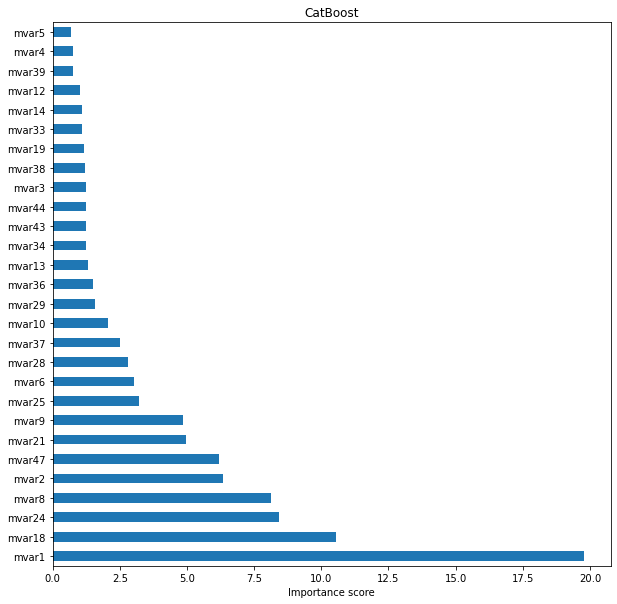

In [89]:
plot_fi(ccat_cols + cnum_cols, cbbest['model'].feature_importances_, 'CatBoost')

In [157]:
ccat_cols = [i for i in cat_cols if i in chosen]
cnum_cols = [i for i in num_cols if i in chosen]
imputer = ColumnTransformer([('mode', IterativeImputer(initial_strategy = 'most_frequent'), ccat_cols),
                             ('median', IterativeImputer(initial_strategy = 'median'), cnum_cols)])
    
gnb = Pipeline([('imp', imputer), 
                ('df', DFTransformer(ccat_cols + cnum_cols)),
                ('ss', StandardScaler()),
                ('model', GaussianNB())])

In [92]:
gnb_score_new = cross_validate(gnb, n_data, target, cv = 5, scoring = 'f1', return_train_score = True)

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Earl

In [93]:
gnb_score_new['test_score'].mean()

0.5688451580463519

In [94]:
gnb_score_new['train_score'].mean()

0.5682612889495626

## Neural Network

In [158]:
x_train, x_test, y_train, y_test = train_test_split(n_data[chosen], target)

In [159]:
nn = keras.Sequential([keras.layers.Dense(100, activation = 'relu'), keras.layers.Dense(100, activation = 'relu'),
                       keras.layers.Dense(1, activation = 'sigmoid')])

In [160]:
nn.compile(optimizer = 'adam', loss = keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [161]:
nn_tr = Pipeline([('imp', imputer), 
                ('df', DFTransformer(ccat_cols + cnum_cols)),
                ('ss', StandardScaler())])

In [162]:
x_train = nn_tr.fit_transform(x_train)
x_test = nn_tr.transform(x_test)

In [163]:
lrs = keras.callbacks.ReduceLROnPlateau(patience = 5, factor = 0.1)
es = keras.callbacks.EarlyStopping(patience = 6, restore_best_weights= True)

In [164]:
nn.fit(x_train, y_train, epochs = 20, validation_split = 0.2, callbacks = [lrs, es])

Epoch 1/20
1557/1557 [==============================] - 7s 4ms/step - loss: 0.5032 - accuracy: 0.7611 - val_loss: 0.4987 - val_accuracy: 0.7622 - lr: 0.0010
Epoch 2/20
1557/1557 [==============================] - 7s 4ms/step - loss: 0.4940 - accuracy: 0.7666 - val_loss: 0.4977 - val_accuracy: 0.7641 - lr: 0.0010
Epoch 3/20
1557/1557 [==============================] - 7s 4ms/step - loss: 0.4914 - accuracy: 0.7678 - val_loss: 0.4990 - val_accuracy: 0.7639 - lr: 0.0010
Epoch 4/20
1557/1557 [==============================] - 6s 4ms/step - loss: 0.4899 - accuracy: 0.7693 - val_loss: 0.4978 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 5/20
1557/1557 [==============================] - 7s 4ms/step - loss: 0.4877 - accuracy: 0.7691 - val_loss: 0.4992 - val_accuracy: 0.7659 - lr: 0.0010
Epoch 6/20
1557/1557 [==============================] - 7s 4ms/step - loss: 0.4862 - accuracy: 0.7706 - val_loss: 0.4977 - val_accuracy: 0.7651 - lr: 0.0010
Epoch 7/20
1557/1557 [==============================] - 7s

In [165]:
nn.evaluate(x_test, y_test)

649/649 [==============================] - 2s 2ms/step - loss: 0.4934 - accuracy: 0.7670


[0.4933851659297943, 0.7670361399650574]

In [166]:
train_pred = nn.predict(x_train)
test_pred = nn.predict(x_test)

## Training models with PCA

In [177]:
mods1_pca = create_models_PCA(chosen, n_data, target, 5, 10)

Training LR
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Train: 0.5252366865027522, Test: 0.5248329164219834
----------------------------------------------------------------------
Traning XGB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train: 0.5293297087228108, Test: 0.526739313119486
----------------------------------------------------------------------
Training LGBM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train: 0.5358444557523899, Test: 0.5317149592340719
----------------------------------------------------------------------
Training CB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fittin

138:	learn: 0.5673730	total: 1.81s	remaining: 13ms
139:	learn: 0.5671878	total: 1.82s	remaining: 0us
Train: 0.5834837095636572, Test: 0.5424071737620194
----------------------------------------------------------------------
Voting Classifier CV
{'fit_time': array([83.39214373, 82.81896877, 83.73023796, 84.76643181, 84.64874935]), 'score_time': array([0.70910144, 0.7686522 , 0.72702336, 1.14943767, 0.90708375]), 'test_score': array([0.53491104, 0.5414673 , 0.53707774, 0.54468363, 0.53661773]), 'train_score': array([0.55383988, 0.55197984, 0.55544884, 0.5511004 , 0.55343998])}


In [178]:
mods1_pca_20 = create_models_PCA(chosen, n_data, target, 5, 20)

Training LR
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train: 0.5589395153183225, Test: 0.5587330944629136
----------------------------------------------------------------------
Traning XGB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:51:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train: 0.5314037138866972, Test: 0.5285614943476726
----------------------------------------------------------------------
Training LGBM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train: 0.6315924746058954, Test: 0.5624560154038146
----------------------------------------------------------------------
Training CB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitti

138:	learn: 0.5592768	total: 4.26s	remaining: 2.02s
139:	learn: 0.5590483	total: 4.29s	remaining: 1.99s
140:	learn: 0.5588908	total: 4.32s	remaining: 1.96s
141:	learn: 0.5587441	total: 4.34s	remaining: 1.93s
142:	learn: 0.5586229	total: 4.37s	remaining: 1.89s
143:	learn: 0.5583865	total: 4.4s	remaining: 1.86s
144:	learn: 0.5582623	total: 4.42s	remaining: 1.83s
145:	learn: 0.5580753	total: 4.45s	remaining: 1.8s
146:	learn: 0.5578323	total: 4.47s	remaining: 1.76s
147:	learn: 0.5575662	total: 4.51s	remaining: 1.74s
148:	learn: 0.5574510	total: 4.53s	remaining: 1.7s
149:	learn: 0.5572779	total: 4.56s	remaining: 1.67s
150:	learn: 0.5571231	total: 4.58s	remaining: 1.64s
151:	learn: 0.5569568	total: 4.61s	remaining: 1.61s
152:	learn: 0.5568424	total: 4.63s	remaining: 1.57s
153:	learn: 0.5566532	total: 4.66s	remaining: 1.54s
154:	learn: 0.5564139	total: 4.69s	remaining: 1.51s
155:	learn: 0.5561675	total: 4.72s	remaining: 1.48s
156:	learn: 0.5560887	total: 4.74s	remaining: 1.45s
157:	learn: 0.5

In [180]:
mods1_pca_30 = create_models_PCA(chosen, n_data, target, 5, 25)

Training LR
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Train: 0.570954891483191, Test: 0.5699658246958168
----------------------------------------------------------------------
Traning XGB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train: 0.5585975902891649, Test: 0.5575517583998392
----------------------------------------------------------------------
Training LGBM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train: 0.6285025735314363, Test: 0.5748668451989375
----------------------------------------------------------------------
Training CB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitti

145:	learn: 0.5293180	total: 3.6s	remaining: 2.44s
146:	learn: 0.5292196	total: 3.62s	remaining: 2.41s
147:	learn: 0.5289619	total: 3.64s	remaining: 2.38s
148:	learn: 0.5286020	total: 3.67s	remaining: 2.36s
149:	learn: 0.5283590	total: 3.69s	remaining: 2.34s
150:	learn: 0.5277545	total: 3.72s	remaining: 2.31s
151:	learn: 0.5272624	total: 3.75s	remaining: 2.29s
152:	learn: 0.5268388	total: 3.77s	remaining: 2.27s
153:	learn: 0.5267772	total: 3.8s	remaining: 2.24s
154:	learn: 0.5265788	total: 3.82s	remaining: 2.22s
155:	learn: 0.5264921	total: 3.85s	remaining: 2.19s
156:	learn: 0.5261149	total: 3.87s	remaining: 2.17s
157:	learn: 0.5258962	total: 3.9s	remaining: 2.15s
158:	learn: 0.5257435	total: 3.93s	remaining: 2.13s
159:	learn: 0.5256495	total: 3.95s	remaining: 2.1s
160:	learn: 0.5251183	total: 3.98s	remaining: 2.07s
161:	learn: 0.5248692	total: 4s	remaining: 2.05s
162:	learn: 0.5247604	total: 4.03s	remaining: 2.02s
163:	learn: 0.5244911	total: 4.05s	remaining: 2s
164:	learn: 0.5243506	

In [181]:
mods1_pca_15 =  create_models_PCA(chosen, n_data, target, 5, 15)

Training LR
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Train: 0.5536009639932404, Test: 0.5530733515920575
----------------------------------------------------------------------
Traning XGB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:18:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train: 0.5388955373267342, Test: 0.53688096079354
----------------------------------------------------------------------
Training LGBM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Train: 0.5570719595042297, Test: 0.5488921442954078
----------------------------------------------------------------------
Training CB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting

140:	learn: 0.4995243	total: 2.24s	remaining: 764ms
141:	learn: 0.4990633	total: 2.26s	remaining: 748ms
142:	learn: 0.4987713	total: 2.27s	remaining: 730ms
143:	learn: 0.4980912	total: 2.29s	remaining: 715ms
144:	learn: 0.4975316	total: 2.3s	remaining: 699ms
145:	learn: 0.4968554	total: 2.32s	remaining: 684ms
146:	learn: 0.4965877	total: 2.33s	remaining: 667ms
147:	learn: 0.4963363	total: 2.35s	remaining: 651ms
148:	learn: 0.4961397	total: 2.36s	remaining: 634ms
149:	learn: 0.4957302	total: 2.38s	remaining: 619ms
150:	learn: 0.4951335	total: 2.4s	remaining: 604ms
151:	learn: 0.4946624	total: 2.42s	remaining: 588ms
152:	learn: 0.4943737	total: 2.43s	remaining: 572ms
153:	learn: 0.4938364	total: 2.45s	remaining: 556ms
154:	learn: 0.4938358	total: 2.45s	remaining: 538ms
155:	learn: 0.4932286	total: 2.47s	remaining: 522ms
156:	learn: 0.4927131	total: 2.48s	remaining: 506ms
157:	learn: 0.4921472	total: 2.5s	remaining: 491ms
158:	learn: 0.4917352	total: 2.52s	remaining: 476ms
159:	learn: 0.4

In [184]:
mods_final = create_models(chosen1, n_data, target, 20)

Training LR
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, to

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Train: 0.5808557689060468, Test: 0.5802367141556495
----------------------------------------------------------------------
Traning XGB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidate

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train: 0.648989303143043, Test: 0.5895704122592114
----------------------------------------------------------------------
Training LGBM
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for eac

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


Train: 0.6034681623147402, Test: 0.5886896717103094
----------------------------------------------------------------------
Training CB
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidate

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0:	learn: 0.6908458	total: 42.6ms	remaining: 16.1s
1:	learn: 0.6886359	total: 76.3ms	remaining: 14.4s
2:	learn: 0.6864519	total: 111ms	remaining: 14s
3:	learn: 0.6842955	total: 143ms	remaining: 13.4s
4:	learn: 0.6822771	total: 174ms	remaining: 13.1s
5:	learn: 0.6802532	total: 208ms	remaining: 13s
6:	learn: 0.6782432	total: 239ms	remaining: 12.7s
7:	learn: 0.6762360	total: 270ms	remaining: 12.6s
8:	learn: 0.6743265	total: 301ms	remaining: 12.4s
9:	learn: 0.6724680	total: 332ms	remaining: 12.3s
10:	learn: 0.6706064	total: 365ms	remaining: 12.2s
11:	learn: 0.6688295	total: 397ms	remaining: 12.2s
12:	learn: 0.6670720	total: 428ms	remaining: 12.1s
13:	learn: 0.6652993	total: 465ms	remaining: 12.2s
14:	learn: 0.6636261	total: 498ms	remaining: 12.1s
15:	learn: 0.6619500	total: 537ms	remaining: 12.2s
16:	learn: 0.6603480	total: 568ms	remaining: 12.1s
17:	learn: 0.6587194	total: 600ms	remaining: 12.1s
18:	learn: 0.6571934	total: 631ms	remaining: 12s
19:	learn: 0.6556676	total: 661ms	remaining: 

166:	learn: 0.5714866	total: 5.39s	remaining: 6.88s
167:	learn: 0.5713007	total: 5.42s	remaining: 6.84s
168:	learn: 0.5711439	total: 5.46s	remaining: 6.81s
169:	learn: 0.5709941	total: 5.49s	remaining: 6.78s
170:	learn: 0.5708435	total: 5.52s	remaining: 6.75s
171:	learn: 0.5706751	total: 5.55s	remaining: 6.71s
172:	learn: 0.5705107	total: 5.58s	remaining: 6.68s
173:	learn: 0.5703463	total: 5.62s	remaining: 6.65s
174:	learn: 0.5702191	total: 5.65s	remaining: 6.61s
175:	learn: 0.5700729	total: 5.68s	remaining: 6.58s
176:	learn: 0.5699056	total: 5.71s	remaining: 6.55s
177:	learn: 0.5697578	total: 5.74s	remaining: 6.52s
178:	learn: 0.5696076	total: 5.77s	remaining: 6.48s
179:	learn: 0.5694707	total: 5.8s	remaining: 6.45s
180:	learn: 0.5693279	total: 5.83s	remaining: 6.42s
181:	learn: 0.5691804	total: 5.86s	remaining: 6.38s
182:	learn: 0.5690326	total: 5.89s	remaining: 6.34s
183:	learn: 0.5689045	total: 5.92s	remaining: 6.31s
184:	learn: 0.5687870	total: 5.95s	remaining: 6.28s
185:	learn: 0

328:	learn: 0.5580227	total: 10.8s	remaining: 1.67s
329:	learn: 0.5579833	total: 10.8s	remaining: 1.64s
330:	learn: 0.5579364	total: 10.9s	remaining: 1.61s
331:	learn: 0.5578956	total: 10.9s	remaining: 1.58s
332:	learn: 0.5578548	total: 10.9s	remaining: 1.54s
333:	learn: 0.5578185	total: 11s	remaining: 1.51s
334:	learn: 0.5577819	total: 11s	remaining: 1.48s
335:	learn: 0.5577387	total: 11s	remaining: 1.44s
336:	learn: 0.5576965	total: 11.1s	remaining: 1.41s
337:	learn: 0.5576598	total: 11.1s	remaining: 1.38s
338:	learn: 0.5576251	total: 11.1s	remaining: 1.34s
339:	learn: 0.5575792	total: 11.1s	remaining: 1.31s
340:	learn: 0.5575344	total: 11.2s	remaining: 1.28s
341:	learn: 0.5574917	total: 11.2s	remaining: 1.24s
342:	learn: 0.5574434	total: 11.2s	remaining: 1.21s
343:	learn: 0.5574047	total: 11.3s	remaining: 1.18s
344:	learn: 0.5573631	total: 11.3s	remaining: 1.14s
345:	learn: 0.5573293	total: 11.3s	remaining: 1.11s
346:	learn: 0.5572865	total: 11.3s	remaining: 1.08s
347:	learn: 0.5572

In [186]:
vc_final = mods_final[4]

In [187]:
vc_final.fit(n_data, target)

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0:	learn: 0.6908458	total: 43.9ms	remaining: 16.6s
1:	learn: 0.6886359	total: 86.3ms	remaining: 16.3s
2:	learn: 0.6864519	total: 128ms	remaining: 16.1s
3:	learn: 0.6842955	total: 169ms	remaining: 15.8s
4:	learn: 0.6822771	total: 207ms	remaining: 15.6s
5:	learn: 0.6802532	total: 248ms	remaining: 15.5s
6:	learn: 0.6782432	total: 322ms	remaining: 17.2s
7:	learn: 0.6762360	total: 379ms	remaining: 17.6s
8:	learn: 0.6743265	total: 418ms	remaining: 17.2s
9:	learn: 0.6724680	total: 457ms	remaining: 16.9s
10:	learn: 0.6706064	total: 496ms	remaining: 16.6s
11:	learn: 0.6688295	total: 537ms	remaining: 16.5s
12:	learn: 0.6670720	total: 573ms	remaining: 16.2s
13:	learn: 0.6652993	total: 614ms	remaining: 16.1s
14:	learn: 0.6636261	total: 655ms	remaining: 15.9s
15:	learn: 0.6619500	total: 695ms	remaining: 15.8s
16:	learn: 0.6603480	total: 735ms	remaining: 15.7s
17:	learn: 0.6587194	total: 786ms	remaining: 15.8s
18:	learn: 0.6571934	total: 828ms	remaining: 15.7s
19:	learn: 0.6556676	total: 867ms	remai

162:	learn: 0.5721561	total: 6.83s	remaining: 9.09s
163:	learn: 0.5719842	total: 6.87s	remaining: 9.05s
164:	learn: 0.5718160	total: 6.92s	remaining: 9.02s
165:	learn: 0.5716511	total: 6.97s	remaining: 8.99s
166:	learn: 0.5714866	total: 7.02s	remaining: 8.95s
167:	learn: 0.5713007	total: 7.06s	remaining: 8.91s
168:	learn: 0.5711439	total: 7.1s	remaining: 8.86s
169:	learn: 0.5709941	total: 7.14s	remaining: 8.82s
170:	learn: 0.5708435	total: 7.18s	remaining: 8.77s
171:	learn: 0.5706751	total: 7.21s	remaining: 8.73s
172:	learn: 0.5705107	total: 7.26s	remaining: 8.69s
173:	learn: 0.5703463	total: 7.3s	remaining: 8.64s
174:	learn: 0.5702191	total: 7.34s	remaining: 8.6s
175:	learn: 0.5700729	total: 7.38s	remaining: 8.55s
176:	learn: 0.5699056	total: 7.42s	remaining: 8.5s
177:	learn: 0.5697578	total: 7.46s	remaining: 8.46s
178:	learn: 0.5696076	total: 7.5s	remaining: 8.42s
179:	learn: 0.5694707	total: 7.53s	remaining: 8.37s
180:	learn: 0.5693279	total: 7.57s	remaining: 8.33s
181:	learn: 0.569

325:	learn: 0.5581556	total: 13.1s	remaining: 2.17s
326:	learn: 0.5581081	total: 13.2s	remaining: 2.13s
327:	learn: 0.5580697	total: 13.2s	remaining: 2.09s
328:	learn: 0.5580227	total: 13.2s	remaining: 2.05s
329:	learn: 0.5579833	total: 13.3s	remaining: 2.01s
330:	learn: 0.5579364	total: 13.3s	remaining: 1.97s
331:	learn: 0.5578956	total: 13.3s	remaining: 1.93s
332:	learn: 0.5578548	total: 13.4s	remaining: 1.89s
333:	learn: 0.5578185	total: 13.4s	remaining: 1.85s
334:	learn: 0.5577819	total: 13.4s	remaining: 1.81s
335:	learn: 0.5577387	total: 13.5s	remaining: 1.76s
336:	learn: 0.5576965	total: 13.5s	remaining: 1.73s
337:	learn: 0.5576598	total: 13.6s	remaining: 1.69s
338:	learn: 0.5576251	total: 13.6s	remaining: 1.64s
339:	learn: 0.5575792	total: 13.6s	remaining: 1.6s
340:	learn: 0.5575344	total: 13.7s	remaining: 1.56s
341:	learn: 0.5574917	total: 13.7s	remaining: 1.52s
342:	learn: 0.5574434	total: 13.7s	remaining: 1.48s
343:	learn: 0.5574047	total: 13.8s	remaining: 1.44s
344:	learn: 0

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('imp',
                                               ColumnTransformer(transformers=[('mode',
                                                                                IterativeImputer(initial_strategy='most_frequent'),
                                                                                ['mvar16',
                                                                                 'mvar17',
                                                                                 'mvar18',
                                                                                 'mvar19',
                                                                                 'mvar20',
                                                                                 'mvar34',
                                                                                 'mvar39',
                                                    

In [195]:
confusion_matrix(target, vc_final.predict(n_data))

array([[43515, 15630],
       [ 6574, 17281]], dtype=int64)

In [202]:
scores = cross_validate(vc_final, n_data, target, cv = 5, scoring = {'prec': make_scorer(precision_score),
                                                                     'acc': make_scorer(accuracy_score),
                                                                     'rec': make_scorer(recall_score),
                                                                     'f1': make_scorer(f1_score)})

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:30:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0:	learn: 0.6908913	total: 33.7ms	remaining: 12.8s
1:	learn: 0.6887669	total: 64.5ms	remaining: 12.2s
2:	learn: 0.6865904	total: 94ms	remaining: 11.8s
3:	learn: 0.6845106	total: 125ms	remaining: 11.8s
4:	learn: 0.6824353	total: 156ms	remaining: 11.7s
5:	learn: 0.6803397	total: 183ms	remaining: 11.4s
6:	learn: 0.6783835	total: 212ms	remaining: 11.3s
7:	learn: 0.6764808	total: 240ms	remaining: 11.2s
8:	learn: 0.6746088	total: 273ms	remaining: 11.2s
9:	learn: 0.6726979	total: 301ms	remaining: 11.1s
10:	learn: 0.6709428	total: 329ms	remaining: 11s
11:	learn: 0.6691611	total: 358ms	remaining: 11s
12:	learn: 0.6674381	total: 387ms	remaining: 10.9s
13:	learn: 0.6656747	total: 415ms	remaining: 10.9s
14:	learn: 0.6639752	total: 444ms	remaining: 10.8s
15:	learn: 0.6622381	total: 471ms	remaining: 10.7s
16:	learn: 0.6605291	total: 506ms	remaining: 10.8s
17:	learn: 0.6589444	total: 536ms	remaining: 10.8s
18:	learn: 0.6573577	total: 568ms	remaining: 10.8s
19:	learn: 0.6557715	total: 597ms	remaining:

166:	learn: 0.5703704	total: 4.76s	remaining: 6.08s
167:	learn: 0.5701883	total: 4.79s	remaining: 6.04s
168:	learn: 0.5700316	total: 4.82s	remaining: 6.01s
169:	learn: 0.5698598	total: 4.84s	remaining: 5.99s
170:	learn: 0.5696920	total: 4.87s	remaining: 5.96s
171:	learn: 0.5695340	total: 4.9s	remaining: 5.92s
172:	learn: 0.5693725	total: 4.93s	remaining: 5.89s
173:	learn: 0.5692104	total: 4.95s	remaining: 5.87s
174:	learn: 0.5690539	total: 4.98s	remaining: 5.84s
175:	learn: 0.5689193	total: 5.01s	remaining: 5.81s
176:	learn: 0.5687699	total: 5.04s	remaining: 5.78s
177:	learn: 0.5686321	total: 5.07s	remaining: 5.75s
178:	learn: 0.5684851	total: 5.09s	remaining: 5.72s
179:	learn: 0.5683537	total: 5.12s	remaining: 5.69s
180:	learn: 0.5682100	total: 5.14s	remaining: 5.66s
181:	learn: 0.5680699	total: 5.17s	remaining: 5.63s
182:	learn: 0.5679386	total: 5.21s	remaining: 5.6s
183:	learn: 0.5677849	total: 5.23s	remaining: 5.58s
184:	learn: 0.5676431	total: 5.26s	remaining: 5.54s
185:	learn: 0.

331:	learn: 0.5560313	total: 9.15s	remaining: 1.32s
332:	learn: 0.5559912	total: 9.18s	remaining: 1.29s
333:	learn: 0.5559527	total: 9.21s	remaining: 1.27s
334:	learn: 0.5559033	total: 9.23s	remaining: 1.24s
335:	learn: 0.5558492	total: 9.26s	remaining: 1.21s
336:	learn: 0.5558044	total: 9.3s	remaining: 1.19s
337:	learn: 0.5557629	total: 9.33s	remaining: 1.16s
338:	learn: 0.5557195	total: 9.36s	remaining: 1.13s
339:	learn: 0.5556755	total: 9.39s	remaining: 1.1s
340:	learn: 0.5556253	total: 9.41s	remaining: 1.08s
341:	learn: 0.5555846	total: 9.44s	remaining: 1.05s
342:	learn: 0.5555397	total: 9.47s	remaining: 1.02s
343:	learn: 0.5555068	total: 9.5s	remaining: 995ms
344:	learn: 0.5554549	total: 9.53s	remaining: 966ms
345:	learn: 0.5554144	total: 9.55s	remaining: 939ms
346:	learn: 0.5553787	total: 9.57s	remaining: 911ms
347:	learn: 0.5553400	total: 9.6s	remaining: 883ms
348:	learn: 0.5552915	total: 9.62s	remaining: 855ms
349:	learn: 0.5552403	total: 9.65s	remaining: 827ms
350:	learn: 0.55

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your 

[16:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0:	learn: 0.6908752	total: 33.6ms	remaining: 12.7s
1:	learn: 0.6886726	total: 61.2ms	remaining: 11.6s
2:	learn: 0.6865267	total: 90.2ms	remaining: 11.3s
3:	learn: 0.6845084	total: 121ms	remaining: 11.4s
4:	learn: 0.6823931	total: 149ms	remaining: 11.2s
5:	learn: 0.6803061	total: 175ms	remaining: 10.9s
6:	learn: 0.6783053	total: 202ms	remaining: 10.8s
7:	learn: 0.6764422	total: 230ms	remaining: 10.7s
8:	learn: 0.6746099	total: 264ms	remaining: 10.9s
9:	learn: 0.6728347	total: 298ms	remaining: 11s
10:	learn: 0.6709764	total: 324ms	remaining: 10.9s
11:	learn: 0.6691496	total: 353ms	remaining: 10.8s
12:	learn: 0.6674421	total: 382ms	remaining: 10.8s
13:	learn: 0.6657649	total: 409ms	remaining: 10.7s
14:	learn: 0.6640869	total: 437ms	remaining: 10.6s
15:	learn: 0.6624234	total: 465ms	remaining: 10.6s
16:	learn: 0.6607829	total: 499ms	remaining: 10.7s
17:	learn: 0.6591765	total: 527ms	remaining: 10.6s
18:	learn: 0.6576416	total: 554ms	remaining: 10.5s
19:	learn: 0.6560475	total: 581ms	remain

165:	learn: 0.5713652	total: 4.74s	remaining: 6.11s
166:	learn: 0.5711942	total: 4.76s	remaining: 6.07s
167:	learn: 0.5710225	total: 4.79s	remaining: 6.04s
168:	learn: 0.5708529	total: 4.82s	remaining: 6.02s
169:	learn: 0.5706941	total: 4.85s	remaining: 5.99s
170:	learn: 0.5705286	total: 4.88s	remaining: 5.96s
171:	learn: 0.5703608	total: 4.91s	remaining: 5.93s
172:	learn: 0.5702216	total: 4.94s	remaining: 5.91s
173:	learn: 0.5700760	total: 4.97s	remaining: 5.89s
174:	learn: 0.5699315	total: 5s	remaining: 5.86s
175:	learn: 0.5697653	total: 5.03s	remaining: 5.83s
176:	learn: 0.5696279	total: 5.06s	remaining: 5.8s
177:	learn: 0.5694978	total: 5.09s	remaining: 5.77s
178:	learn: 0.5693536	total: 5.12s	remaining: 5.74s
179:	learn: 0.5691873	total: 5.14s	remaining: 5.71s
180:	learn: 0.5690363	total: 5.17s	remaining: 5.69s
181:	learn: 0.5688766	total: 5.2s	remaining: 5.66s
182:	learn: 0.5687441	total: 5.23s	remaining: 5.63s
183:	learn: 0.5685996	total: 5.25s	remaining: 5.6s
184:	learn: 0.5684

325:	learn: 0.5572554	total: 9.05s	remaining: 1.5s
326:	learn: 0.5572099	total: 9.08s	remaining: 1.47s
327:	learn: 0.5571709	total: 9.11s	remaining: 1.44s
328:	learn: 0.5571355	total: 9.13s	remaining: 1.42s
329:	learn: 0.5570879	total: 9.16s	remaining: 1.39s
330:	learn: 0.5570365	total: 9.18s	remaining: 1.36s
331:	learn: 0.5569920	total: 9.21s	remaining: 1.33s
332:	learn: 0.5569546	total: 9.23s	remaining: 1.3s
333:	learn: 0.5569129	total: 9.26s	remaining: 1.27s
334:	learn: 0.5568732	total: 9.29s	remaining: 1.25s
335:	learn: 0.5568257	total: 9.31s	remaining: 1.22s
336:	learn: 0.5567844	total: 9.34s	remaining: 1.19s
337:	learn: 0.5567423	total: 9.37s	remaining: 1.16s
338:	learn: 0.5567087	total: 9.39s	remaining: 1.14s
339:	learn: 0.5566644	total: 9.42s	remaining: 1.11s
340:	learn: 0.5566191	total: 9.44s	remaining: 1.08s
341:	learn: 0.5565806	total: 9.46s	remaining: 1.05s
342:	learn: 0.5565398	total: 9.49s	remaining: 1.02s
343:	learn: 0.5565022	total: 9.52s	remaining: 996ms
344:	learn: 0.

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your 

[16:32:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0:	learn: 0.6908366	total: 47.8ms	remaining: 18.1s
1:	learn: 0.6886859	total: 77.4ms	remaining: 14.6s
2:	learn: 0.6864867	total: 104ms	remaining: 13.1s
3:	learn: 0.6844210	total: 132ms	remaining: 12.4s
4:	learn: 0.6823352	total: 159ms	remaining: 11.9s
5:	learn: 0.6802267	total: 187ms	remaining: 11.6s
6:	learn: 0.6782216	total: 214ms	remaining: 11.4s
7:	learn: 0.6762768	total: 243ms	remaining: 11.3s
8:	learn: 0.6744540	total: 277ms	remaining: 11.4s
9:	learn: 0.6725680	total: 303ms	remaining: 11.2s
10:	learn: 0.6707290	total: 329ms	remaining: 11s
11:	learn: 0.6690574	total: 358ms	remaining: 11s
12:	learn: 0.6672725	total: 386ms	remaining: 10.9s
13:	learn: 0.6655145	total: 411ms	remaining: 10.8s
14:	learn: 0.6638263	total: 441ms	remaining: 10.7s
15:	learn: 0.6621075	total: 470ms	remaining: 10.7s
16:	learn: 0.6604553	total: 500ms	remaining: 10.7s
17:	learn: 0.6589493	total: 530ms	remaining: 10.7s
18:	learn: 0.6574012	total: 557ms	remaining: 10.6s
19:	learn: 0.6558153	total: 585ms	remaining

168:	learn: 0.5713432	total: 4.76s	remaining: 5.95s
169:	learn: 0.5711873	total: 4.79s	remaining: 5.91s
170:	learn: 0.5710178	total: 4.82s	remaining: 5.89s
171:	learn: 0.5708510	total: 4.84s	remaining: 5.86s
172:	learn: 0.5706809	total: 4.87s	remaining: 5.83s
173:	learn: 0.5705202	total: 4.9s	remaining: 5.8s
174:	learn: 0.5703793	total: 4.92s	remaining: 5.77s
175:	learn: 0.5702235	total: 4.95s	remaining: 5.74s
176:	learn: 0.5700764	total: 4.98s	remaining: 5.71s
177:	learn: 0.5699148	total: 5s	remaining: 5.68s
178:	learn: 0.5697633	total: 5.03s	remaining: 5.65s
179:	learn: 0.5696031	total: 5.06s	remaining: 5.62s
180:	learn: 0.5694619	total: 5.08s	remaining: 5.59s
181:	learn: 0.5693212	total: 5.11s	remaining: 5.56s
182:	learn: 0.5691861	total: 5.14s	remaining: 5.53s
183:	learn: 0.5690395	total: 5.17s	remaining: 5.5s
184:	learn: 0.5688981	total: 5.2s	remaining: 5.48s
185:	learn: 0.5687569	total: 5.22s	remaining: 5.45s
186:	learn: 0.5686187	total: 5.25s	remaining: 5.42s
187:	learn: 0.56848

331:	learn: 0.5575417	total: 9.11s	remaining: 1.32s
332:	learn: 0.5574998	total: 9.13s	remaining: 1.29s
333:	learn: 0.5574603	total: 9.16s	remaining: 1.26s
334:	learn: 0.5574147	total: 9.19s	remaining: 1.23s
335:	learn: 0.5573660	total: 9.22s	remaining: 1.21s
336:	learn: 0.5573250	total: 9.24s	remaining: 1.18s
337:	learn: 0.5572698	total: 9.27s	remaining: 1.15s
338:	learn: 0.5572339	total: 9.29s	remaining: 1.12s
339:	learn: 0.5571961	total: 9.33s	remaining: 1.1s
340:	learn: 0.5571501	total: 9.37s	remaining: 1.07s
341:	learn: 0.5571133	total: 9.4s	remaining: 1.04s
342:	learn: 0.5570801	total: 9.42s	remaining: 1.02s
343:	learn: 0.5570442	total: 9.45s	remaining: 989ms
344:	learn: 0.5570042	total: 9.47s	remaining: 961ms
345:	learn: 0.5569692	total: 9.5s	remaining: 933ms
346:	learn: 0.5569194	total: 9.52s	remaining: 906ms
347:	learn: 0.5568871	total: 9.55s	remaining: 878ms
348:	learn: 0.5568459	total: 9.57s	remaining: 851ms
349:	learn: 0.5567996	total: 9.6s	remaining: 823ms
350:	learn: 0.55

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your 

[16:32:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0:	learn: 0.6909223	total: 31ms	remaining: 11.7s
1:	learn: 0.6887601	total: 60.2ms	remaining: 11.4s
2:	learn: 0.6865927	total: 87.6ms	remaining: 11s
3:	learn: 0.6845750	total: 117ms	remaining: 11s
4:	learn: 0.6825267	total: 144ms	remaining: 10.8s
5:	learn: 0.6805286	total: 172ms	remaining: 10.7s
6:	learn: 0.6785839	total: 201ms	remaining: 10.7s
7:	learn: 0.6767027	total: 228ms	remaining: 10.6s
8:	learn: 0.6747937	total: 257ms	remaining: 10.6s
9:	learn: 0.6729781	total: 284ms	remaining: 10.5s
10:	learn: 0.6711839	total: 311ms	remaining: 10.4s
11:	learn: 0.6694854	total: 338ms	remaining: 10.4s
12:	learn: 0.6677486	total: 365ms	remaining: 10.3s
13:	learn: 0.6660404	total: 393ms	remaining: 10.3s
14:	learn: 0.6643588	total: 425ms	remaining: 10.3s
15:	learn: 0.6626876	total: 453ms	remaining: 10.3s
16:	learn: 0.6610499	total: 483ms	remaining: 10.3s
17:	learn: 0.6594127	total: 512ms	remaining: 10.3s
18:	learn: 0.6579211	total: 541ms	remaining: 10.3s
19:	learn: 0.6563913	total: 569ms	remaining:

166:	learn: 0.5723700	total: 4.66s	remaining: 5.94s
167:	learn: 0.5722153	total: 4.68s	remaining: 5.91s
168:	learn: 0.5720569	total: 4.71s	remaining: 5.88s
169:	learn: 0.5718993	total: 4.74s	remaining: 5.85s
170:	learn: 0.5717387	total: 4.76s	remaining: 5.82s
171:	learn: 0.5715656	total: 4.79s	remaining: 5.79s
172:	learn: 0.5714167	total: 4.81s	remaining: 5.76s
173:	learn: 0.5712593	total: 4.84s	remaining: 5.73s
174:	learn: 0.5711126	total: 4.87s	remaining: 5.71s
175:	learn: 0.5709506	total: 4.9s	remaining: 5.68s
176:	learn: 0.5708009	total: 4.93s	remaining: 5.65s
177:	learn: 0.5706301	total: 4.95s	remaining: 5.62s
178:	learn: 0.5704908	total: 4.98s	remaining: 5.59s
179:	learn: 0.5703501	total: 5s	remaining: 5.56s
180:	learn: 0.5702157	total: 5.03s	remaining: 5.53s
181:	learn: 0.5700663	total: 5.06s	remaining: 5.5s
182:	learn: 0.5699231	total: 5.08s	remaining: 5.47s
183:	learn: 0.5697717	total: 5.11s	remaining: 5.45s
184:	learn: 0.5696262	total: 5.14s	remaining: 5.42s
185:	learn: 0.569

325:	learn: 0.5584801	total: 8.82s	remaining: 1.46s
326:	learn: 0.5584319	total: 8.85s	remaining: 1.43s
327:	learn: 0.5583958	total: 8.87s	remaining: 1.41s
328:	learn: 0.5583490	total: 8.89s	remaining: 1.38s
329:	learn: 0.5583062	total: 8.92s	remaining: 1.35s
330:	learn: 0.5582635	total: 8.95s	remaining: 1.32s
331:	learn: 0.5582219	total: 8.97s	remaining: 1.3s
332:	learn: 0.5581854	total: 9s	remaining: 1.27s
333:	learn: 0.5581315	total: 9.02s	remaining: 1.24s
334:	learn: 0.5580816	total: 9.05s	remaining: 1.22s
335:	learn: 0.5580392	total: 9.07s	remaining: 1.19s
336:	learn: 0.5580036	total: 9.09s	remaining: 1.16s
337:	learn: 0.5579611	total: 9.12s	remaining: 1.13s
338:	learn: 0.5579237	total: 9.15s	remaining: 1.11s
339:	learn: 0.5578779	total: 9.17s	remaining: 1.08s
340:	learn: 0.5578415	total: 9.19s	remaining: 1.05s
341:	learn: 0.5578087	total: 9.21s	remaining: 1.02s
342:	learn: 0.5577697	total: 9.24s	remaining: 997ms
343:	learn: 0.5577405	total: 9.26s	remaining: 969ms
344:	learn: 0.55

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your 

[16:33:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


0:	learn: 0.6909724	total: 31.1ms	remaining: 11.8s
1:	learn: 0.6888166	total: 58.2ms	remaining: 11s
2:	learn: 0.6867428	total: 87.2ms	remaining: 11s
3:	learn: 0.6846260	total: 115ms	remaining: 10.8s
4:	learn: 0.6825522	total: 141ms	remaining: 10.6s
5:	learn: 0.6805562	total: 170ms	remaining: 10.6s
6:	learn: 0.6786439	total: 197ms	remaining: 10.5s
7:	learn: 0.6767308	total: 225ms	remaining: 10.4s
8:	learn: 0.6748357	total: 258ms	remaining: 10.6s
9:	learn: 0.6729394	total: 288ms	remaining: 10.6s
10:	learn: 0.6711737	total: 313ms	remaining: 10.5s
11:	learn: 0.6694258	total: 343ms	remaining: 10.5s
12:	learn: 0.6677246	total: 375ms	remaining: 10.6s
13:	learn: 0.6660454	total: 408ms	remaining: 10.7s
14:	learn: 0.6643739	total: 438ms	remaining: 10.7s
15:	learn: 0.6626511	total: 464ms	remaining: 10.6s
16:	learn: 0.6609795	total: 494ms	remaining: 10.5s
17:	learn: 0.6593249	total: 522ms	remaining: 10.5s
18:	learn: 0.6577626	total: 548ms	remaining: 10.4s
19:	learn: 0.6562309	total: 574ms	remainin

168:	learn: 0.5719800	total: 4.77s	remaining: 5.96s
169:	learn: 0.5718060	total: 4.8s	remaining: 5.93s
170:	learn: 0.5716501	total: 4.82s	remaining: 5.89s
171:	learn: 0.5714867	total: 4.85s	remaining: 5.86s
172:	learn: 0.5713199	total: 4.88s	remaining: 5.83s
173:	learn: 0.5711580	total: 4.91s	remaining: 5.81s
174:	learn: 0.5710009	total: 4.93s	remaining: 5.78s
175:	learn: 0.5708611	total: 4.96s	remaining: 5.75s
176:	learn: 0.5707007	total: 4.99s	remaining: 5.72s
177:	learn: 0.5705469	total: 5.01s	remaining: 5.69s
178:	learn: 0.5703947	total: 5.04s	remaining: 5.66s
179:	learn: 0.5702485	total: 5.06s	remaining: 5.63s
180:	learn: 0.5701139	total: 5.09s	remaining: 5.6s
181:	learn: 0.5699684	total: 5.12s	remaining: 5.57s
182:	learn: 0.5698359	total: 5.15s	remaining: 5.54s
183:	learn: 0.5696935	total: 5.18s	remaining: 5.51s
184:	learn: 0.5695577	total: 5.21s	remaining: 5.49s
185:	learn: 0.5694251	total: 5.23s	remaining: 5.46s
186:	learn: 0.5692832	total: 5.26s	remaining: 5.43s
187:	learn: 0.

332:	learn: 0.5580229	total: 9.08s	remaining: 1.28s
333:	learn: 0.5579828	total: 9.11s	remaining: 1.25s
334:	learn: 0.5579454	total: 9.13s	remaining: 1.23s
335:	learn: 0.5578992	total: 9.15s	remaining: 1.2s
336:	learn: 0.5578553	total: 9.18s	remaining: 1.17s
337:	learn: 0.5577997	total: 9.2s	remaining: 1.14s
338:	learn: 0.5577516	total: 9.23s	remaining: 1.11s
339:	learn: 0.5577098	total: 9.25s	remaining: 1.09s
340:	learn: 0.5576757	total: 9.27s	remaining: 1.06s
341:	learn: 0.5576342	total: 9.3s	remaining: 1.03s
342:	learn: 0.5575900	total: 9.32s	remaining: 1s
343:	learn: 0.5575489	total: 9.35s	remaining: 979ms
344:	learn: 0.5575073	total: 9.37s	remaining: 951ms
345:	learn: 0.5574694	total: 9.39s	remaining: 923ms
346:	learn: 0.5574268	total: 9.42s	remaining: 896ms
347:	learn: 0.5573910	total: 9.45s	remaining: 869ms
348:	learn: 0.5573402	total: 9.47s	remaining: 841ms
349:	learn: 0.5573026	total: 9.49s	remaining: 814ms
350:	learn: 0.5572720	total: 9.52s	remaining: 787ms
351:	learn: 0.5572

C:\Users\mayur\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\mayur\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


In [203]:
scores

{'fit_time': array([56.18609428, 57.43283081, 55.76532793, 57.26951623, 57.01159716]),
 'score_time': array([0.60836959, 0.61635041, 0.60535407, 0.6293149 , 0.57645869]),
 'test_prec': array([0.52903659, 0.49395836, 0.50116144, 0.51059643, 0.50709541]),
 'test_acc': array([0.73343373, 0.70759036, 0.71355422, 0.7210241 , 0.71825301]),
 'test_rec': array([0.66065814, 0.71117166, 0.72353804, 0.70697967, 0.70404527]),
 'test_f1': array([0.58756641, 0.58298969, 0.59216056, 0.59295069, 0.58955682])}